# NLP-Project 2: Sentiment Analysis and Modeling for Amazon Reviews to Increase Sales (Kozmos Dataset)

### Business Problem

Kozmos, ein Unternehmen, das Heimtextilien und Alltagskleidung herstellt und über Amazon verkauft, strebt an, seine Verkaufszahlen zu steigern.
Um dieses Ziel zu erreichen, werden Kundenbewertungen analysiert und auf Grundlage der erhaltenen Beschwerden Produktmerkmale verbessert.
Dazu werden die Bewertungen einer Sentiment-Analyse unterzogen und entsprechend etikettiert.
Mit den etikettierten Daten wird anschließend ein Klassifikationsmodell erstellt.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

In [3]:
data = pd.read_excel(r"C:\Users\Naime Diler\Desktop\PycharmProjects\5. Natural Language Processing (NLP)/15. week/amazon.xlsx")
df = data.copy()
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [ ]:
df['Review'].head(10)

## 1. Text Preprocessing

In [16]:
# Für die "Review"-Variable:


def text_preprocessing(text):
    # 1. Konvertieren aller Buchstaben in Kleinbuchstaben (Normalizing Case Folding).
    # 2. Entfernen von Satzzeichen (Punctuations).
    # 3. Entfernen von numerischen Ausdrücken in den Bewertungen (Numbers):
    text = text.str.lower().\
    replace('[^\w\s]', '', regex=True).\
    replace('\n', '', regex=True).\
    replace('\d', '', regex=True)
    
    # Entfernen von "Stopwords", die keine relevanten Informationen enthalten:
    # nltk.download('stopwords') 
    sw = stopwords.words("english")
    if isinstance(text, (pd.DataFrame, pd.Series)) and text.isnull().any().any():
        text = text.fillna("")
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in sw))

    # Entfernen von Wörtern, die weniger als 100 Mal im Datensatz vorkommen (Rarewords):
    temp = pd.Series(" ".join(text).split()).value_counts()
    drops = temp[temp < 100]
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in drops))

    # Durchführung der Lemmatisierung (Lemmatization):
    lemmatizer = WordNetLemmatizer()
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x.split()])
    text = text.apply(lambda x: " ".join(x))

    return text




df["Review"] = text_preprocessing(df["Review"])
df['Review'].head(10)

0                                                happy
1                          good quality material panel
2             product bedroom bit still material sheer
3                                                     
4            great cant quality material vibrant color
5                                 look different photo
6           exactly looking heavy material great price
7    looking picture thought curtain would sheer ni...
8                        much thought would really use
9    curtain picture set curtain one set use one se...
Name: Review, dtype: object

## 2. Text Visualization

#### Barplot

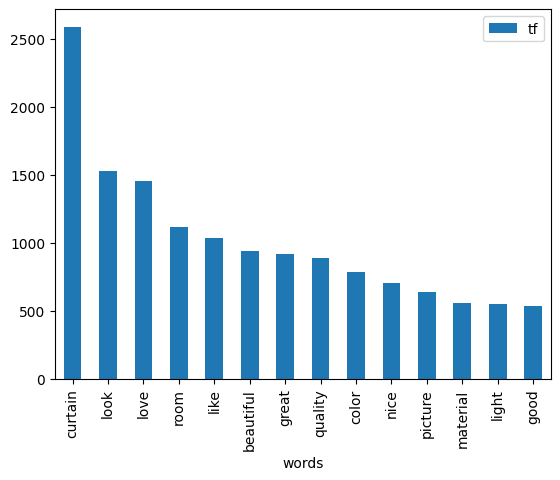

In [17]:
# Barplot Visualisierung:
# 1. Berechnung der Wortfrequenzen in der "Review"-Variable und Speicherung als tf (Term Frequency)
# 2. Umbenennung der Spalten im tf DataFrame in "words" und "tf"
# 3. Filtern von tf, um nur Wörter mit einer Häufigkeit von mehr als 500 zu behalten und Darstellung als Balkendiagramm.


def tf_visual (text):
    tf = text.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns = ["words", "tf"]
    tf = tf.sort_values("tf", ascending=False)
    tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
    plt.show()


tf_visual(df["Review"])

#### Wordcloud

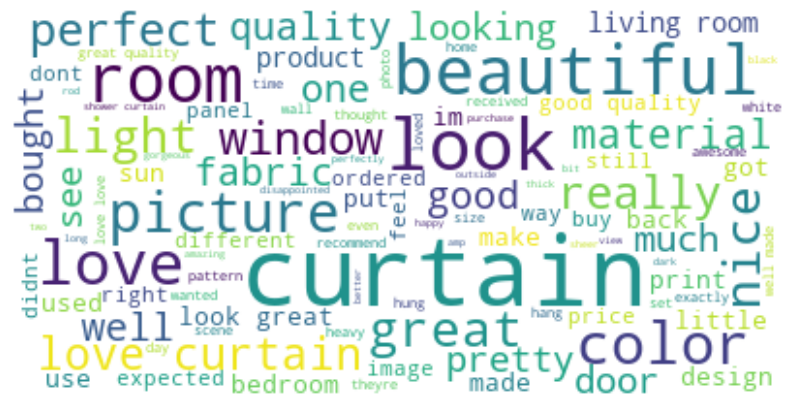

In [19]:
# WordCloud Visualisierung:
# 1. Speichern aller Wörter aus der "Review"-Variable als String mit dem Namen "text"
# 2. Definieren und Speichern des Layouts für die WordCloud
# 3. Generieren der WordCloud mit dem gespeicherten "text"-String
# 4. Durchführen der Visualisierung (Erstellung der Grafik mit figure, imshow, axis, show)



def word_cloud(text, name):
    text = " ".join(i for i in text)
    wordcloud = WordCloud(max_font_size=50,
                          max_words=100,
                          background_color="white").generate(text)
    wordcloud.generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    # wordcloud.to_file(name)

word_cloud(df["Review"], name = "amazon111.png")

## 3. Sentiment Analysis

In [20]:
# Erstellen des SentimentIntensityAnalyzer-Objekts aus der NLTK-Bibliothek in Python.

sia = SentimentIntensityAnalyzer()

#### Analyse der Polaritätsbewertungen mit dem SentimentIntensityAnalyzer-Objekt

In [24]:
# Berechnung der Polaritätscores für die ersten 10 Beobachtungen der "Review"-Variable.

pd.set_option('display.max_colwidth', None)

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0          {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
1      {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
2             {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
3             {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
4    {'neg': 0.255, 'neu': 0.368, 'pos': 0.377, 'compound': 0.3235}
5             {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
6      {'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'compound': 0.6249}
7      {'neg': 0.0, 'neu': 0.595, 'pos': 0.405, 'compound': 0.7778}
8             {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
9      {'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'compound': 0.7096}
Name: Review, dtype: object

In [22]:
# Filtern der ersten 10 Beobachtungen basierend auf den Compound-Scores.

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.00
3   0.00
4   0.32
5   0.00
6   0.62
7   0.78
8   0.00
9   0.71
Name: Review, dtype: float64

In [25]:
# Zuweisung von "pos" oder "neg" für die ersten 10 Beobachtungen basierend auf den Compound-Scores:

df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    neg
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [26]:
# Hinzufügen einer neuen Variable "sentiment_label" zum DataFrame, basierend auf der pos-neg Zuordnung für alle Beobachtungen in "Review".

df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["sentiment_label"].value_counts()

sentiment_label
pos    4409
neg    1202
Name: count, dtype: int64

In [28]:
# Durchschnittliche Sterne für jedes Sentiment_Label:

df.groupby("sentiment_label")["Star"].mean()

sentiment_label
neg   3.85
pos   4.56
Name: Star, dtype: float64

In [ ]:
df2 = df.copy()

# Konvertierung der "sentiment_label"-Variable von kategorischen Werten in numerische Werte.
# LabelEncoder wird verwendet, um die Labels "pos" und "neg" in numerische Werte umzuwandeln.
# "pos" wird als 1 und "neg" als 0 kodiert.


#df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])
#df["sentiment_label"] = df["sentiment_label"].replace("pos", 1).replace("neg", 0)

## 4. Vorbereitung auf maschinelles Lernen

In [29]:
# Definition der abhängigen Variable (y) als "sentiment_label" und der unabhängigen Variable (X) als "Review".

y = df["sentiment_label"]
X = df["Review"]

# Aufteilung der Daten in Trainings- und Testsets, wobei der Zufallszustand auf 17 gesetzt ist.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

# Vorbereitung der Daten für das Maschinenlernmodell mit TfidfVectorizer.
# 1. Erstellung eines TfidfVectorizer-Objekts.
# 2. Anpassung des Objekts an die Trainingsdaten (X_train).

tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)

# Transformation der Trainings- und Testdaten (X_train und X_test) mit dem TfidfVectorizer.
X_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

## 5. Modellierung 

### Logistische Regression

In [30]:
# Erstellung eines logistischen Regressionsmodells und Anpassung an die Trainingsdaten.
lm = LogisticRegression()
lm.fit(X_train_tf_idf_word, y_train)

# Durchführung von Vorhersagen mit dem erstellten Modell:
# Vorhersage der Testdaten mit der predict-Funktion und Speichern der Ergebnisse.
y_pred = lm.predict(X_test_tf_idf_word)

In [31]:
# Berichterstellung der Vorhersageergebnisse mit classification_report.

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         neg       0.91      0.99      0.95       297
         pos       1.00      0.97      0.98      1106

    accuracy                           0.98      1403
   macro avg       0.95      0.98      0.97      1403
weighted avg       0.98      0.98      0.98      1403



In [32]:
# Berechnen des durchschnittlichen Genauigkeitswerts (accuracy) mithilfe der Cross-Validation-Funktion.

cross_val_score(lm,
                X_train_tf_idf_word,
                y_train,
                scoring="accuracy",
                cv=5).mean()

0.9721943393934944

#### Zufällige Auswahl eines Kommentars aus den verfügbaren Daten und Vorhersage mit dem Modell:

In [37]:
# Auswahl eines Beispiels aus der Spalte "Review" mit der sample-Funktion.
r_review = pd.Series(df["Review"].sample(1).values)

print(r_review)

0    curtain beautiful love window little feel recommend
dtype: object


In [38]:
# 1. Vektorisierung des ausgewählten Beispiels mithilfe von CountVectorizer, um es für das Modell vorzubereiten.
# 2. Anwendung von fit und transform auf das vektorisierte Beispiel.

new_comment = CountVectorizer().fit(X_train).transform(r_review)

# Vorhersage mit dem trainierten Modell auf das ausgewählte Beispiel.
pred = lm.predict(new_comment)

# e. Ausgabe des ausgewählten Beispiels und der Vorhersage.
print(f"Review: {r_review[0]}")
print(f"Predict: {pred}")

Review: curtain beautiful love window little feel recommend
Predict: ['pos']


### Random Forests

#### Count Vectors

In [42]:
# Erstellung eines CountVectorizer-Objekts und Anpassung an die Trainingsdaten.
X_train_vector = CountVectorizer().fit(X_train)

# Transformation der Trainings- und Testdaten in Count-Vektoren.
X_train_world = X_train_vector.transform(X_train)
X_test_world = X_train_vector.transform(X_test)

# Training eines Random Forest Klassifikators mit den Count-Vektoren und Berechnung der durchschnittlichen Genauigkeit.
rf_model = RandomForestClassifier().fit(X_train_world, y_train)
count_vector_accuracy = cross_val_score(rf_model, X_train_world, y_train, cv=5, n_jobs=-1).mean()
#  0.9222916390113568


print(f"Durchschnittliche Genauigkeit mit Count-Vektoren: {count_vector_accuracy}")

Durchschnittliche Genauigkeit mit Count-Vektoren: 0.9824123526736919


#### TF-IDF Word-Level

In [43]:
# Training eines Random Forest Klassifikators mit TF-IDF gewichteten Wort-Vektoren und Berechnung der durchschnittlichen 
# Genauigkeit.
rf_model = RandomForestClassifier().fit(X_train_tf_idf_word, y_train)
tf_idf_word_accuracy = cross_val_score(rf_model, X_train_tf_idf_word, y_train, cv=5, n_jobs=-1).mean()

print(f"Durchschnittliche Genauigkeit mit TF-IDF Word-Level: {tf_idf_word_accuracy}")

Durchschnittliche Genauigkeit mit TF-IDF Word-Level: 0.979323336939115


#### TF-IDF n-Gramme

In [44]:
# TF-IDF Vektorisierung mit n-Grammen (2-Gramme).
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 2))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit(X_train).transform(X_train)

# Training eines Random Forest Klassifikators mit TF-IDF n-Grammen und Berechnung der durchschnittlichen Genauigkeit.
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y_train)
tf_idf_ngram_accuracy = cross_val_score(rf_model, X_tf_idf_ngram, y_train, cv=5, n_jobs=-1).mean()

print(f"Durchschnittliche Genauigkeit mit TF-IDF n-Grammen: {tf_idf_ngram_accuracy}")

Durchschnittliche Genauigkeit mit TF-IDF n-Grammen: 0.7896913243763081


#### Hyperparameter-Optimierung

In [48]:
# Initialisierung des Random Forest Klassifikators.
rf_model = RandomForestClassifier()

# Definition des Hyperparameter-Rasters für die Optimierung.
rf_params = {"max_depth":[5, 8, None],
             "max_features":[5, 7, "auto"],
             "min_samples_split":[2, 5, 8, 20],
             "n_estimators":[100, 200, 500]}

# Initialisierung von GridSearchCV für die beste Parameterkombination.
rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
rf_best_grid.fit(X_train_tf_idf_word, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 8, None],
                         'max_features': [5, 7, 'auto'],
                         'min_samples_split': [2, 5, 8, 20],
                         'n_estimators': [100, 200, 500]},
             verbose=1)

In [49]:
# Ausgabe der besten gefundenen Parameter.
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [51]:
# Initialisierung und Anpassung des endgültigen Modells mit den besten Parametern.
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17)
rf_final.fit(X_train_tf_idf_word, y_train)

# Berechnung der durchschnittlichen Genauigkeit des endgültigen Modells mit Cross-Validation.
accuracy = cross_val_score(rf_final, X_train_tf_idf_word, y_train, cv=5, n_jobs=-1).mean()

print(f"Durchschnittliche Genauigkeit des Modells: {accuracy}")

Durchschnittliche Genauigkeit des Modells: 0.9738598716040456
